In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import re
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

#### Problem Statement: Predicting Cake Sales, except torta, for the comming holidays
##### Info: Cake is a subcategory and includes torta products

In [114]:
sales = pd.read_csv("Kaldis Sales Data 2022-2024 April.csv")

/var/folders/ww/0nkg0rmj0b9c695dkptvt_hh0000gn/T/ipykernel_722/336106144.py:1: DtypeWarning:

Columns (2,3,5,6,13) have mixed types. Specify dtype option on import or set low_memory=False.



In [115]:
sales.head()

,code,IssuedDate,customerCode,customerName,type,waiterCode,table,cashierCode,cashierName,branchCode,...,sku,productName,childCategory,parentCategory,quantity,unitAmt,totalAmount,taxAmount,serviceCharge,grandTotal
0,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2009,BLACK FOREST CAKE,cake,PASTRY,6.0,66.67,400.02,62.62,17.40,16277.39
1,CASS-00011-MNY1,2022-07-12 20:44:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0006,...,3006,HOT CUP12OZ,Hot cup,OTHER,23.0,8.70,200.10,30.04,NaN,36195.41
2,CASS-00011-MNY1,2022-07-12 20:44:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0006,...,5002,CAFE LATTE TALL,Hot Beverage,BEVERAGE,6.0,52.50,315.00,49.32,13.71,36195.41
3,CASS-00011-MNY1,2022-07-12 20:44:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0006,...,3001,COLD CUP,cup,OTHER,1.0,8.70,8.70,1.31,NaN,36195.41
4,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2006,MILLE-FEIULLE,cake,PASTRY,2.0,58.33,116.66,18.26,5.08,16277.39


In [116]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794878 entries, 0 to 1794877
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   code               object 
 1   IssuedDate         object 
 2   customerCode       object 
 3   customerName       object 
 4   type               object 
 5   waiterCode         object 
 6   table              object 
 7   cashierCode        object 
 8   cashierName        object 
 9   branchCode         object 
 10  branchDescription  object 
 11  shift              object 
 12  fsNo               float64
 13  mrc                object 
 14  sku                object 
 15  productName        object 
 16  childCategory      object 
 17  parentCategory     object 
 18  quantity           float64
 19  unitAmt            float64
 20  totalAmount        float64
 21  taxAmount          float64
 22  serviceCharge      float64
 23  grandTotal         float64
dtypes: float64(7), object(17)
memory usage: 328.7+ MB


In [117]:
sales.columns

Index(['code', 'IssuedDate', 'customerCode', 'customerName', 'type',
       'waiterCode', 'table', 'cashierCode', 'cashierName', 'branchCode',
       'branchDescription', 'shift', 'fsNo', 'mrc', 'sku', 'productName',
       'childCategory', 'parentCategory', 'quantity', 'unitAmt', 'totalAmount',
       'taxAmount', 'serviceCharge', 'grandTotal'],
      dtype='object')

In [118]:
sales.childCategory.value_counts().head(15)

childCategory
Hot Beverage         580775
cake                 493750
Fast Food            200743
Juice                115897
Ice Cream             96163
Bottled Beverage.     87160
Hot cup               45350
milk.                 36272
cup                   34043
AP FAST FOOD          19235
AP HOT BEVERAGE       16205
Pizza                 11357
Yoghurt                6791
MR MAIN COURSES        4620
AP CAKE                4404
Name: count, dtype: int64

In [119]:
# Filtering only cakse
cake = sales[sales['childCategory'] == 'cake']
cake.head()

,code,IssuedDate,customerCode,customerName,type,waiterCode,table,cashierCode,cashierName,branchCode,...,sku,productName,childCategory,parentCategory,quantity,unitAmt,totalAmount,taxAmount,serviceCharge,grandTotal
0,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2009,BLACK FOREST CAKE,cake,PASTRY,6.0,66.67,400.02,62.62,17.40,16277.39
4,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2006,MILLE-FEIULLE,cake,PASTRY,2.0,58.33,116.66,18.26,5.08,16277.39
6,CASS-00010-KLT1,2022-07-12 20:00:47.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2008,WHITE FOREST CAKE,cake,PASTRY,22.0,66.67,1466.74,229.62,63.80,17877.89
7,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2018,TUTI FRUTTI CAKE,cake,PASTRY,5.0,66.67,333.35,52.18,14.50,16277.39
10,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2017,MANGO CAKE,cake,PASTRY,1.0,66.67,66.67,10.44,2.90,16277.39


In [120]:
cake.childCategory.value_counts()

childCategory
cake    493750
Name: count, dtype: int64

In [121]:
# removing torta from cakes
cake = cake[~cake['productName'].str.contains('torta', case=False, na= False)]
cake.head()

,code,IssuedDate,customerCode,customerName,type,waiterCode,table,cashierCode,cashierName,branchCode,...,sku,productName,childCategory,parentCategory,quantity,unitAmt,totalAmount,taxAmount,serviceCharge,grandTotal
0,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2009,BLACK FOREST CAKE,cake,PASTRY,6.0,66.67,400.02,62.62,17.40,16277.39
4,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2006,MILLE-FEIULLE,cake,PASTRY,2.0,58.33,116.66,18.26,5.08,16277.39
6,CASS-00010-KLT1,2022-07-12 20:00:47.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2008,WHITE FOREST CAKE,cake,PASTRY,22.0,66.67,1466.74,229.62,63.80,17877.89
7,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2018,TUTI FRUTTI CAKE,cake,PASTRY,5.0,66.67,333.35,52.18,14.50,16277.39
10,CASS-00030-KLT1,2022-07-22 19:56:27.000,NaN,NaN,LKUP000000853,NaN,NaN,User000000635,Abrham Gezahgn,0018,...,2017,MANGO CAKE,cake,PASTRY,1.0,66.67,66.67,10.44,2.90,16277.39


In [122]:
cake.productName.value_counts()

productName
BANANA CAKE                33507
ASSORTED CAKE              32823
BIGNE 3PCS                 32127
CHOCOLATE MILLE-FEIULLE    31357
MILLE-FEIULLE              31044
BLACK FOREST CAKE          29954
ENGLISH CAKE               28435
BABY CAKE                  27324
BAKLAVA CAKE               23089
WHITE FOREST CAKE          22547
SOFT CAKE                  20998
MACCHIATO CAKE             19842
BELGIUM CHOCOLATE CAKE     18730
FASTING MILLE-FEIULLE      17173
CORKI CAKE                 11779
MANGO CAKE                 10082
COOKIES SMALL               7559
CARAMEL FROSTING CAKE       7414
FASTING TIRAMISU            6922
FASTING B.FOREST            6556
PINEAPPLE CAKE              6430
COOKIES BIG                 5878
TROPICAL CAKE               4245
STROBERRY CAKE              3771
LEMON GATO CAKE             2801
TUTI FRUTTI CAKE            2611
FASTING COOKIES SMALL       1810
BUSH DE NOEL CAKE           1692
FASTING COOKIES BIG         1281
FASTING CORKI CAKE           28

In [123]:
# Slicing important columns relevant to our target varaible quantity
cake = cake[["IssuedDate", "productName","quantity"]]
cake.head()

,IssuedDate,productName,quantity
0,2022-07-22 19:56:27.000,BLACK FOREST CAKE,6.0
4,2022-07-22 19:56:27.000,MILLE-FEIULLE,2.0
6,2022-07-12 20:00:47.000,WHITE FOREST CAKE,22.0
7,2022-07-22 19:56:27.000,TUTI FRUTTI CAKE,5.0
10,2022-07-22 19:56:27.000,MANGO CAKE,1.0


In [124]:
cake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450283 entries, 0 to 1794872
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   IssuedDate   450283 non-null  object 
 1   productName  450283 non-null  object 
 2   quantity     450283 non-null  float64
dtypes: float64(1), object(2)
memory usage: 13.7+ MB


In [125]:
# casting the IssuedDate column from datetime to date, necessary to group sales by day
cake.IssuedDate = pd.to_datetime(cake.IssuedDate)

In [126]:
cake.IssuedDate = cake.IssuedDate.dt.date

In [127]:
cake.head()

,IssuedDate,productName,quantity
0,2022-07-22,BLACK FOREST CAKE,6.0
4,2022-07-22,MILLE-FEIULLE,2.0
6,2022-07-12,WHITE FOREST CAKE,22.0
7,2022-07-22,TUTI FRUTTI CAKE,5.0
10,2022-07-22,MANGO CAKE,1.0


In [128]:
# Considering all cake products will use the same ingredients, otherwise, we need to filter out which cake products would have similar amount of inputs
final_cake = cake.groupby(by="IssuedDate")[["quantity"]].sum()
final_cake.head(20)

,quantity
IssuedDate,
2022-05-04,86.0
2022-05-05,263.0
2022-07-08,2668.0
2022-07-09,6665.0
2022-07-10,6210.0
2022-07-11,4061.0
2022-07-12,5302.0
2022-07-13,3541.0
2022-07-14,4371.0


In [129]:
len(final_cake)

638

#### Timseries Analysis

In [130]:
fig = px.line(final_cake, x=final_cake.index, y="quantity")
fig.show()

##### Visualizing outlier

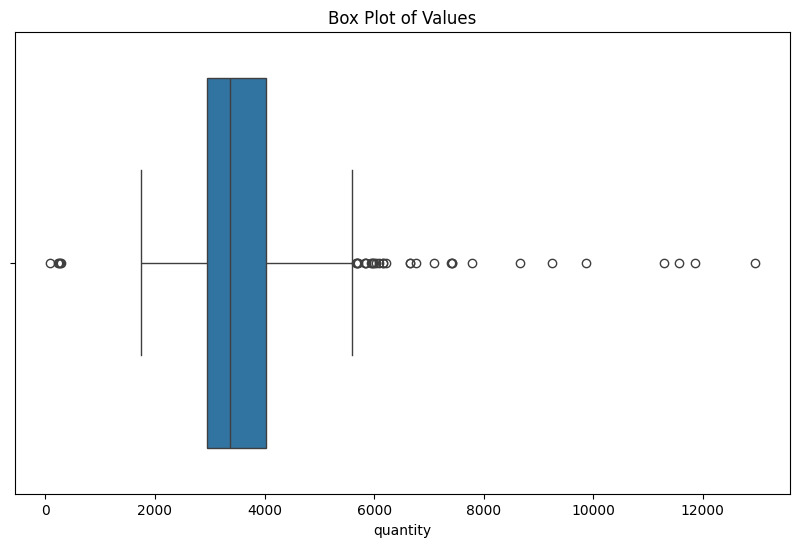

In [131]:
# Creating a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=final_cake['quantity'])
plt.title('Box Plot of Values')
plt.show()

In [132]:
# I am interested in finding dates where we receive higher sales
final_cake.loc[final_cake["quantity"] > 5800, ["quantity"]]

,quantity
IssuedDate,
2022-07-09,6665.0
2022-07-10,6210.0
2022-07-17,7093.0
2022-07-24,6157.0
2022-07-31,6002.0
2022-08-06,7416.0
2022-09-11,11867.0
2022-09-12,7403.0
2022-09-18,6027.0


#### The dates where outlier sales recorded seems to be public holidays and weekends near to public holidays

In [133]:
final_cake.loc[final_cake["quantity"] > 5800, ["quantity"]].mean()

quantity    7581.888889
dtype: float64

### Nurturing my database

In [134]:
# Public Holidays since June 2022 to September 2024
publicHolidays = pd.read_excel("/Users/aaa/Desktop/Kaldis/Kaldis Coffee - Sales Analysis/ML Cake Sales prediction/PublicHolidays.xlsx")
publicHolidays.Date = publicHolidays.Date.dt.date
pd.concat([publicHolidays.head(10), publicHolidays.tail(10)])

,Date,Is public holiday
0,2022-01-06,Eve
1,2022-01-07,Yes
2,2022-01-08,After Holiday
3,2022-01-18,Eve
4,2022-01-19,Yes
5,2022-03-02,Yes
6,2022-04-22,Yes
7,2022-04-23,Eve
8,2022-04-24,Yes
9,2022-05-01,Yes


In [135]:
publicHolidays.set_index("Date", inplace=True)
publicHolidays.head()

,Is public holiday
Date,
2022-01-06,Eve
2022-01-07,Yes
2022-01-08,After Holiday
2022-01-18,Eve
2022-01-19,Yes


In [136]:
publicHolidays["Is public holiday"].value_counts()

Is public holiday
Yes              39
Eve              25
After Holiday    21
No                2
Name: count, dtype: int64

In [137]:
cake_withHoliday = final_cake.merge(publicHolidays, left_index=True, right_index=True, how='left')
cake_withHoliday.head(100)

,quantity,Is public holiday
IssuedDate,,
2022-05-04,86.0,NaN
2022-05-05,263.0,Yes
2022-07-08,2668.0,Eve
2022-07-09,6665.0,Yes
2022-07-10,6210.0,Eve
...,...,...
2022-10-09,4905.0,After Holiday
2022-10-10,3035.0,NaN
2022-10-11,3388.0,NaN


In [138]:
cake_withHoliday["Is public holiday"] = cake_withHoliday["Is public holiday"].fillna("No")

In [139]:
cake_withHoliday["Is public holiday"].value_counts()

Is public holiday
No               598
Yes               18
Eve               12
After Holiday     10
Name: count, dtype: int64

### Linear regression model

In [140]:
# Baseline model
final_cake_withHoliday = cake_withHoliday.drop(columns="Is public holiday")

In [141]:
# Creating lag
final_cake_withHoliday["quantity_2"] = final_cake_withHoliday["quantity"].shift(1)
final_cake_withHoliday.dropna(inplace = True)
final_cake_withHoliday.head()

,quantity,quantity_2
IssuedDate,,
2022-05-05,263.0,86.0
2022-07-08,2668.0,263.0
2022-07-09,6665.0,2668.0
2022-07-10,6210.0,6665.0
2022-07-11,4061.0,6210.0


In [142]:
final_cake_withHoliday.corr()

,quantity,quantity_2
quantity,1.000000,0.344637
quantity_2,0.344637,1.000000


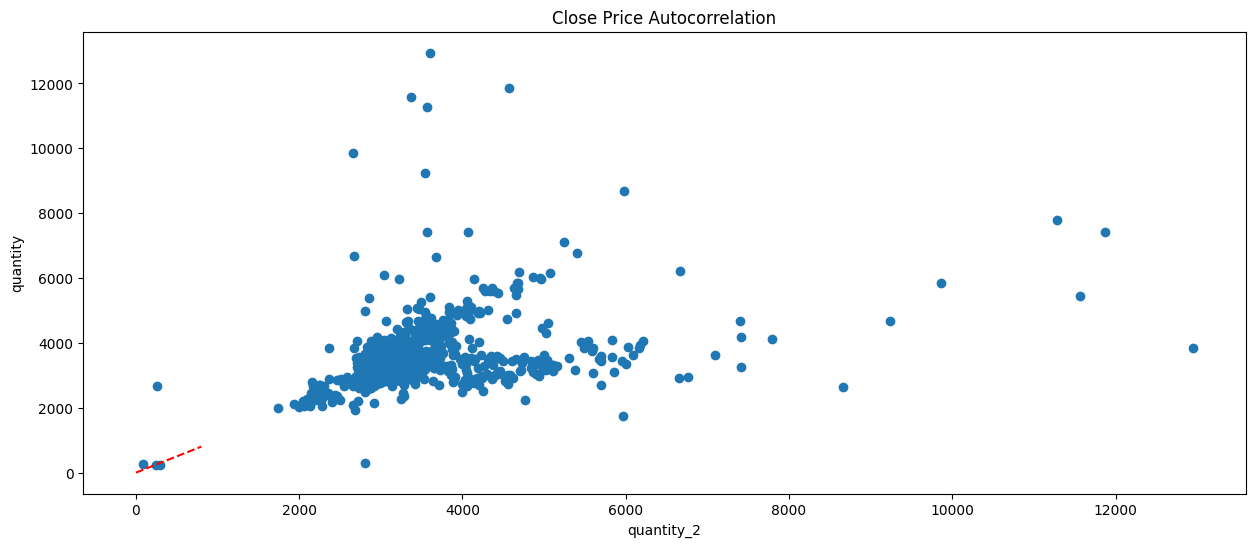

In [143]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(x=final_cake_withHoliday["quantity_2"], y=final_cake_withHoliday["quantity"])
ax.plot([0,800],[0,800],linestyle="--", color="red")
plt.xlabel("quantity_2")
plt.ylabel("quantity")
plt.title("Close Price Autocorrelation");

In [144]:
# Split the data into featuer and target
target = "quantity"
y = final_cake_withHoliday[target]
X = final_cake_withHoliday.drop(columns= target)                                             
#Split the data into train and test sets
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

Baseline Model

In [145]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean Quantity Sold:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean Quantity Sold: 3724.85
Baseline MAE: 775.7


In [146]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
LinearRegression()

LinearRegression()

In [147]:
training_mae = mean_absolute_error(y_train, lin_model.predict(X_train))
test_mae = mean_absolute_error(y_test, lin_model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 742.36
Test MAE: 788.93


In [148]:
df_pred_test = pd.DataFrame(
             {
             "y_test": y_test,
             "y_pred": lin_model.predict(X_test)
             }
)
df_pred_test.head()

,y_test,y_pred
IssuedDate,,
2023-11-28,2694.0,3445.495049
2023-11-29,2826.0,3417.964978
2023-11-30,3075.0,3457.464645
2023-12-01,2822.0,3531.975380
2023-12-02,3259.0,3456.267685


In [149]:
fig = px.line(df_pred_test, labels= {"value": "Close Price"}, title = "Linear Regression Model: Actual Prices vs. Predicted Prices.")
fig.show()

### Predicting with XGBoost

<Axes: ylabel='Frequency'>

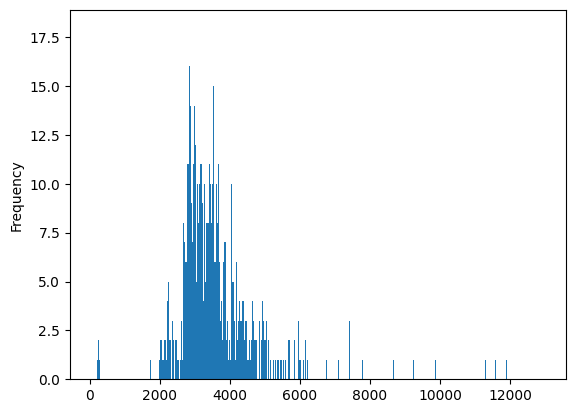

In [150]:
cake_withHoliday['quantity'].plot(kind='hist', bins=500)

### Time Series Cross Validation

In [151]:
# tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = cake_withHoliday.sort_index()

In [152]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df



In [153]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2022-05-04', '2022-05-05', '2022-07-08', '2022-07-09',
               '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15',
               ...
               '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28',
               '2024-03-29', '2024-03-30', '2024-03-31', '2024-04-01',
               '2024-04-02', '2024-04-03'],
              dtype='datetime64[ns]', name='IssuedDate', length=638, freq=None)

In [154]:
df = create_features(df)

In [155]:
df.head()

,quantity,Is public holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
IssuedDate,,,,,,,,,
2022-05-04,86.0,No,2,2,5,2022,124,4,18
2022-05-05,263.0,Yes,3,2,5,2022,125,5,18
2022-07-08,2668.0,Eve,4,3,7,2022,189,8,27
2022-07-09,6665.0,Yes,5,3,7,2022,190,9,27
2022-07-10,6210.0,Eve,6,3,7,2022,191,10,27


In [156]:
# One hot encoding the public holiday and eve column
one_hot_encoded_data = pd.get_dummies(df, columns = ['Is public holiday'])
one_hot_encoded_data

,quantity,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Is public holiday_After Holiday,Is public holiday_Eve,Is public holiday_No,Is public holiday_Yes
IssuedDate,,,,,,,,,,,,
2022-05-04,86.0,2,2,5,2022,124,4,18,False,False,True,False
2022-05-05,263.0,3,2,5,2022,125,5,18,False,False,False,True
2022-07-08,2668.0,4,3,7,2022,189,8,27,False,True,False,False
2022-07-09,6665.0,5,3,7,2022,190,9,27,False,False,False,True
2022-07-10,6210.0,6,3,7,2022,191,10,27,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-30,2158.0,5,1,3,2024,90,30,13,False,False,True,False
2024-03-31,2800.0,6,1,3,2024,91,31,13,False,False,True,False
2024-04-01,291.0,0,2,4,2024,92,1,14,False,False,True,False


In [157]:
# Define a custom function to map True to 1 and False to 0
def map_boolean_to_int(value):
    return 1 if value else 0


In [159]:
# Apply the custom function to the "Is public holiday_Eve" column
one_hot_encoded_data["Is public holiday_Eve"] = one_hot_encoded_data["Is public holiday_Eve"].apply(map_boolean_to_int)
one_hot_encoded_data["Is public holiday_After Eve"] = one_hot_encoded_data["Is public holiday_After Holiday"].apply(map_boolean_to_int)
one_hot_encoded_data["Is public holiday_No"] = one_hot_encoded_data["Is public holiday_No"].apply(map_boolean_to_int)
one_hot_encoded_data["Is public holiday_Yes"] = one_hot_encoded_data["Is public holiday_Yes"].apply(map_boolean_to_int)

In [160]:
one_hot_encoded_data.head()

,quantity,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Is public holiday_After Holiday,Is public holiday_Eve,Is public holiday_No,Is public holiday_Yes,Is public holiday_After Eve
IssuedDate,,,,,,,,,,,,,
2022-05-04,86.0,2,2,5,2022,124,4,18,False,0,1,0,0
2022-05-05,263.0,3,2,5,2022,125,5,18,False,0,0,1,0
2022-07-08,2668.0,4,3,7,2022,189,8,27,False,1,0,0,0
2022-07-09,6665.0,5,3,7,2022,190,9,27,False,0,0,1,0
2022-07-10,6210.0,6,3,7,2022,191,10,27,False,1,0,0,0


In [161]:
one_hot_encoded_data.corr()

,quantity,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Is public holiday_After Holiday,Is public holiday_Eve,Is public holiday_No,Is public holiday_Yes,Is public holiday_After Eve
quantity,1.000000,0.396850,0.011404,-0.013586,-0.156999,-0.012406,0.012621,-0.017168,0.155131,0.002631,-0.310961,0.336726,0.155131
dayofweek,0.396850,1.000000,0.010359,0.014611,-0.009959,0.014668,0.002295,0.004338,0.012725,0.040515,-0.097246,0.099585,0.012725
quarter,0.011404,0.010359,1.000000,0.974395,-0.646824,0.971664,0.022043,0.964922,-0.061082,-0.047441,0.119705,-0.090509,-0.061082
month,-0.013586,0.014611,0.974395,1.000000,-0.635230,0.996849,0.017944,0.988963,-0.073430,-0.065328,0.141603,-0.098629,-0.073430
year,-0.156999,-0.009959,-0.646824,-0.635230,1.000000,-0.634111,-0.033595,-0.629719,0.006547,-0.025245,0.006773,0.005885,0.006547
dayofyear,-0.012406,0.014668,0.971664,0.996849,-0.634111,1.000000,0.096985,0.991509,-0.071101,-0.066867,0.144327,-0.103102,-0.071101
dayofmonth,0.012621,0.002295,0.022043,0.017944,-0.033595,0.096985,1.000000,0.088495,0.023244,-0.022698,0.038974,-0.055873,0.023244
weekofyear,-0.017168,0.004338,0.964922,0.988963,-0.629719,0.991509,0.088495,1.000000,-0.072243,-0.068741,0.148065,-0.106181,-0.072243
Is public holiday_After Holiday,0.155131,0.012725,-0.061082,-0.073430,0.006547,-0.071101,0.023244,-0.072243,1.000000,-0.017471,-0.487911,-0.021501,1.000000
Is public holiday_Eve,0.002631,0.040515,-0.047441,-0.065328,-0.025245,-0.066867,-0.022698,-0.068741,-0.017471,1.000000,-0.535333,-0.023591,-0.017471


#### Visualize our Feature / Target Relationship

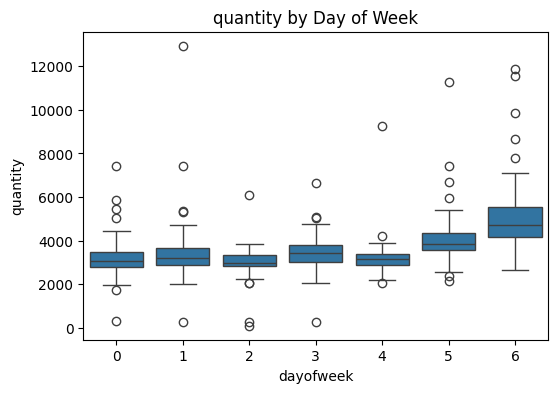

In [162]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=one_hot_encoded_data, x='dayofweek', y='quantity')
ax.set_title('quantity by Day of Week')
plt.show()

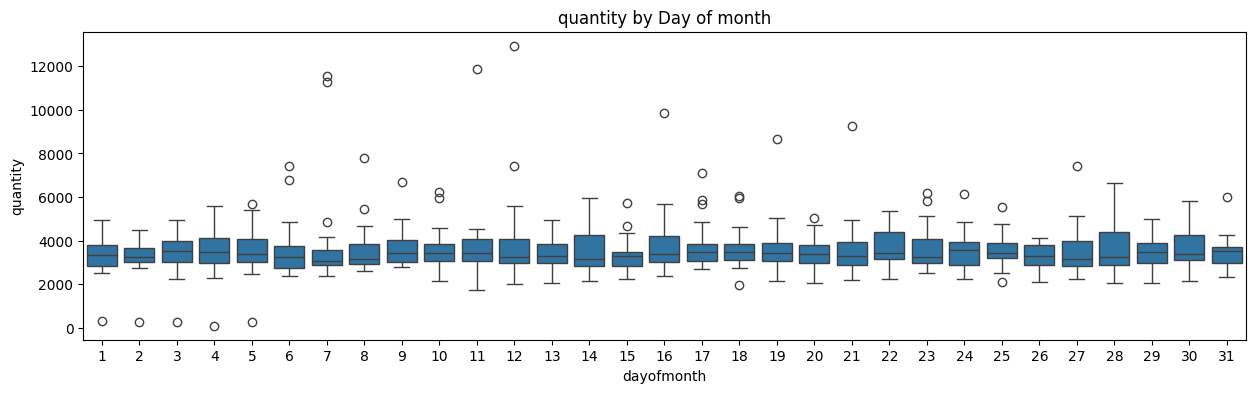

In [163]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=one_hot_encoded_data, x='dayofmonth', y='quantity')
ax.set_title('quantity by Day of month')
plt.show()

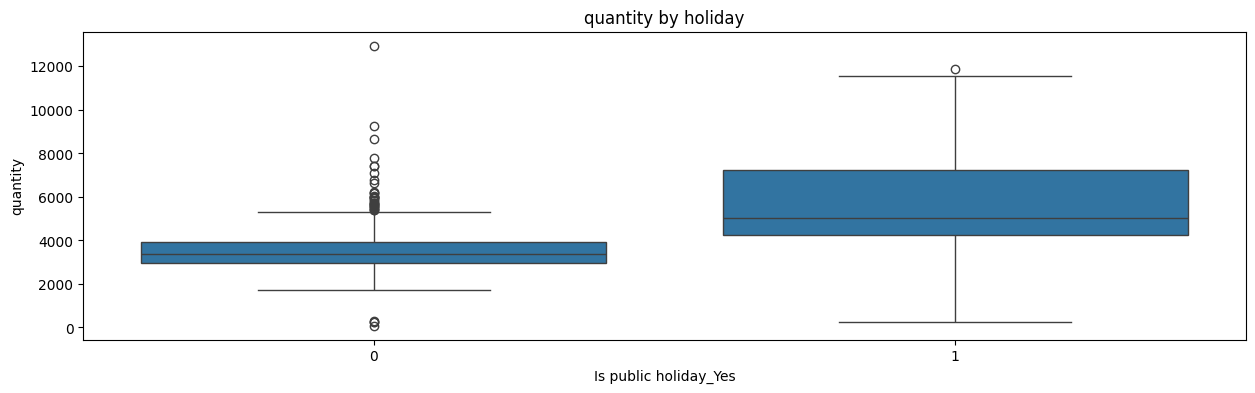

In [164]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=one_hot_encoded_data, x='Is public holiday_Yes', y='quantity')
ax.set_title('quantity by holiday')
plt.show()

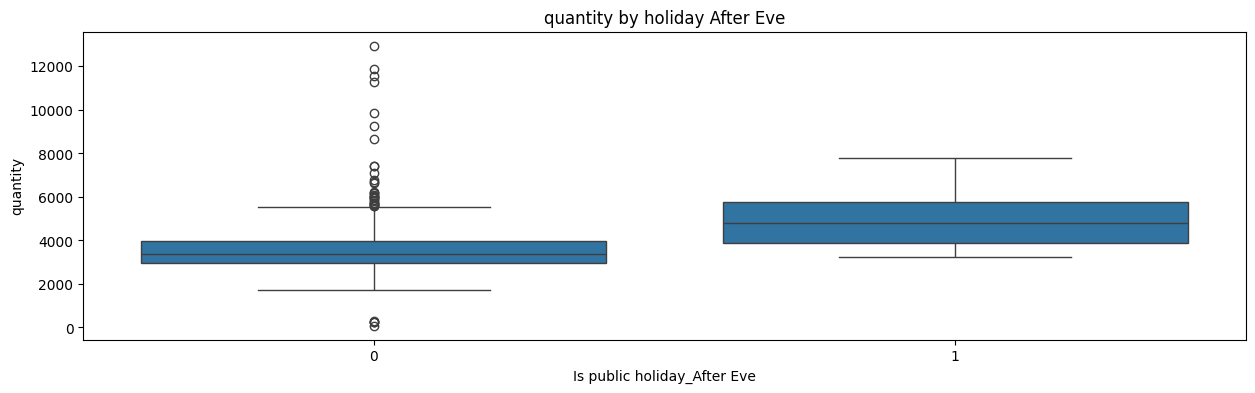

In [165]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=one_hot_encoded_data, x='Is public holiday_After Eve', y='quantity')
ax.set_title('quantity by holiday After Eve')
plt.show()

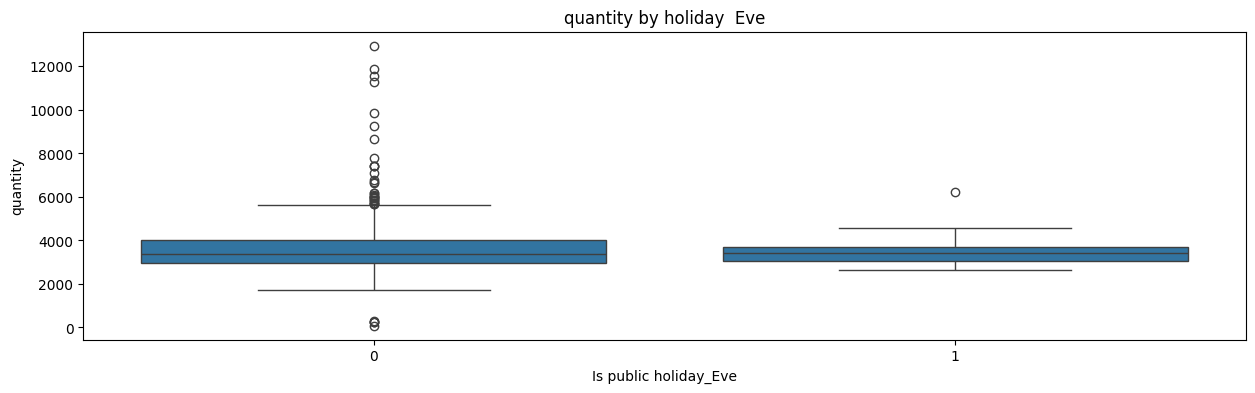

In [166]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=one_hot_encoded_data, x='Is public holiday_Eve', y='quantity')
ax.set_title('quantity by holiday  Eve')
plt.show()

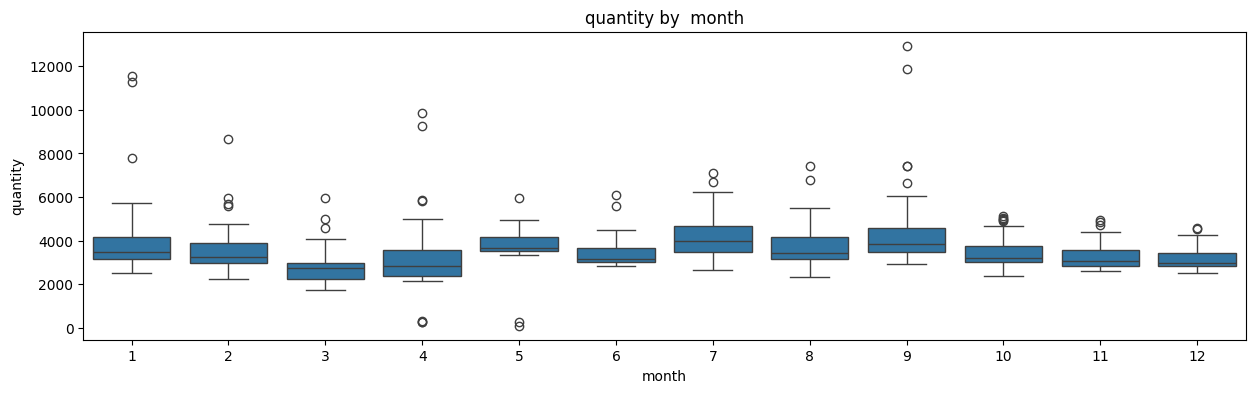

In [167]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=one_hot_encoded_data, x='month', y='quantity')
ax.set_title('quantity by  month')
plt.show()

### Create our Model

In [168]:
one_hot_encoded_data.head()

,quantity,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Is public holiday_After Holiday,Is public holiday_Eve,Is public holiday_No,Is public holiday_Yes,Is public holiday_After Eve
IssuedDate,,,,,,,,,,,,,
2022-05-04,86.0,2,2,5,2022,124,4,18,False,0,1,0,0
2022-05-05,263.0,3,2,5,2022,125,5,18,False,0,0,1,0
2022-07-08,2668.0,4,3,7,2022,189,8,27,False,1,0,0,0
2022-07-09,6665.0,5,3,7,2022,190,9,27,False,0,0,1,0
2022-07-10,6210.0,6,3,7,2022,191,10,27,False,1,0,0,0


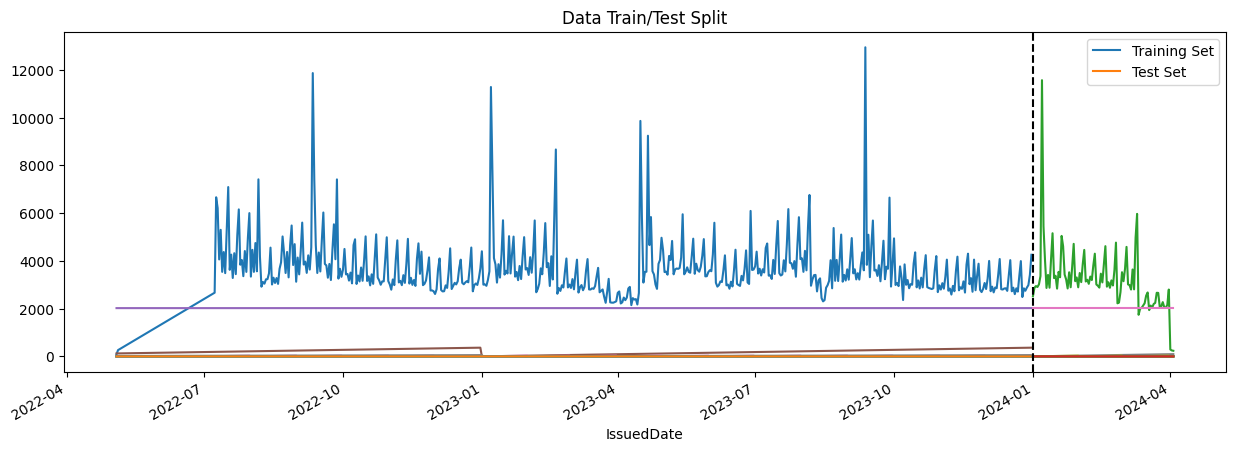

In [169]:

# Assuming 'one_hot_encoded_data' is a DataFrame with datetime index
# and 'cake_withHoliday' is another DataFrame with datetime index

# Convert string to Timestamp
split_date = pd.Timestamp('01-01-2024 00:00:00')

# Filter data for train and test sets
train = one_hot_encoded_data.loc[one_hot_encoded_data.index < split_date]
test = one_hot_encoded_data.loc[one_hot_encoded_data.index >= split_date]

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [170]:
FEATURES = [ 'dayofweek', 'Is public holiday_After Eve', 'Is public holiday_No', 'dayofmonth', 'Is public holiday_Yes']
TARGET = 'quantity'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [171]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree', 
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.03)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:3756.38996	validation_1-rmse:3333.43199
[100]	validation_0-rmse:825.20474	validation_1-rmse:971.28159
[124]	validation_0-rmse:786.03689	validation_1-rmse:1033.43142


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[15:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Feature Importance

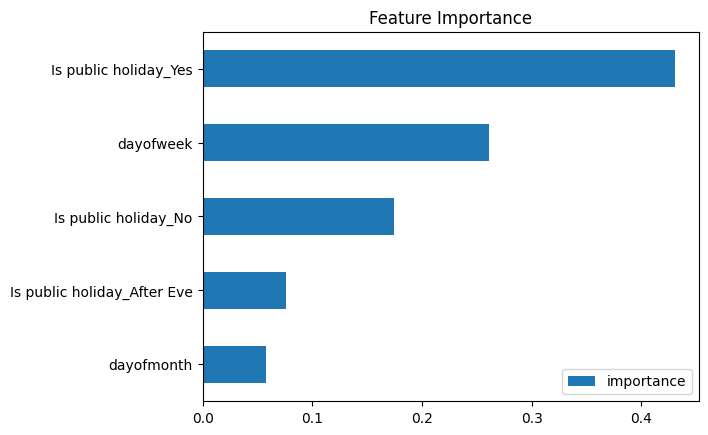

In [172]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forcaste on Test

/var/folders/ww/0nkg0rmj0b9c695dkptvt_hh0000gn/T/ipykernel_722/2771513660.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



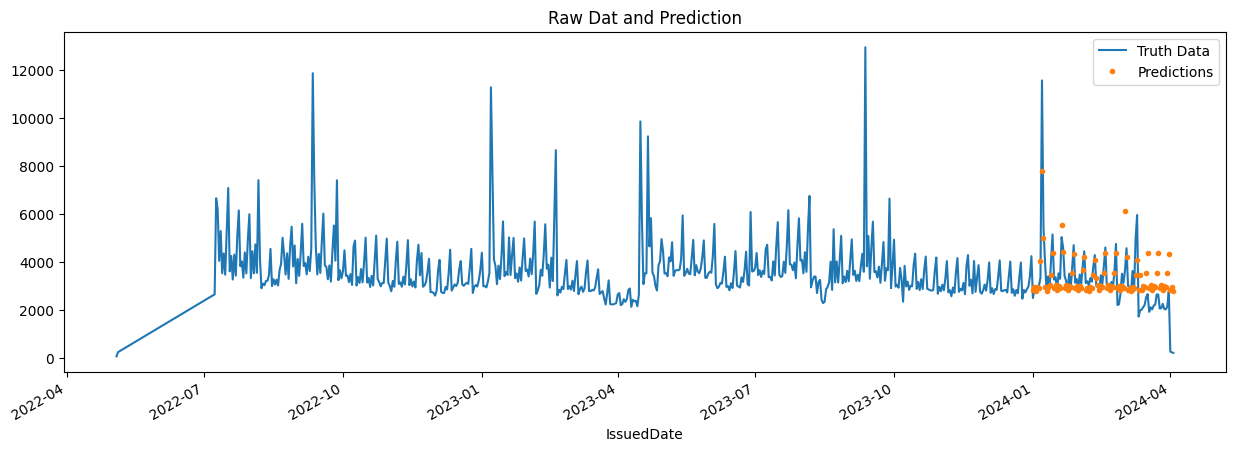

In [173]:
test['prediction'] = reg.predict(X_test)
df = one_hot_encoded_data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['quantity']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

### Score

In [174]:
score = np.sqrt(mean_absolute_error(test['quantity'], test['prediction']))
print(f'MAE Score on Test set: {score:0.2f}')

MAE Score on Test set: 24.85


# XGBoost with Grid Search CV as hyper parameter Tuning

In [175]:
import xgboost
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor


In [176]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

In [177]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [180]:
xgb_grid.fit(X_train,
         y_train)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:32:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:32:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [15:32:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160:

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'min_child_weight': [4],
                         'n_estimators': [500], 'nthread': [4],
                         'objective': ['reg:linear'], 'subsample': [0.7]},
             verbose=True)

In [ ]:
best_params = xgb_grid.best_params_
print(xgb_grid.best_score_)
print(best_params)

-0.047321192682547863
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'subsample': 0.7}


In [181]:
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning:

[15:32:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None, nthread=4,
             num_parallel_tree=None, ...)

In [184]:
# Evaluate the model
mae = mean_absolute_error(y_test, best_model.predict(X_test))
print("Mean Absolute Error:", mae)

Mean Absolute Error: 761.4373493600399


In [185]:
test_pred = best_model.predict(X_test)

In [186]:
X_test["predicted"] = test_pred
X_test["actual"] = y_test
compare_result = X_test[["predicted","actual"]]
compare_result.head()

/var/folders/ww/0nkg0rmj0b9c695dkptvt_hh0000gn/T/ipykernel_722/2561135911.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ww/0nkg0rmj0b9c695dkptvt_hh0000gn/T/ipykernel_722/2561135911.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,predicted,actual
IssuedDate,,
2024-01-01,3147.331787,2516.0
2024-01-02,3583.572266,2872.0
2024-01-03,3074.103760,2946.0
2024-01-04,3261.586914,2907.0
2024-01-05,3497.147705,3019.0


In [187]:
fig = px.line(compare_result, labels= {"value": "Close Price"}, title = "xgboost Model: Actual Prices vs. Predicted Prices.")
fig.show()

In [ ]:
yhat = best_model.predict(predict)

In [ ]:
pred["quantity"] = yhat 
pred.head()

,Is public holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,quantity
Date,,,,,,,,,
2024-04-05,No,4,2,4,2024,96,5,14,3368.253662
2024-04-06,No,5,2,4,2024,97,6,14,5397.986328
2024-04-07,No,6,2,4,2024,98,7,14,4932.774414
2024-04-08,No,0,2,4,2024,99,8,15,3149.144287
2024-04-09,No,1,2,4,2024,100,9,15,3532.360352


In [ ]:
column1 = one_hot_encoded_data["quantity"]
column2 = pred["quantity"]
result_concatnated2 = pd.concat([column1,column2], axis=0)
print(pd.concat([result_concatnated2.head(), result_concatnated.tail()]))

2022-05-04      86.000000
2022-05-05     271.000000
2022-07-08    2740.000000
2022-07-09    7633.000000
2022-07-10    6738.000000
2024-05-26    4264.154297
2024-05-27    2882.034912
2024-05-28    6495.372070
2024-05-29    2942.695068
2024-05-30    3506.090332
Name: quantity, dtype: float64


In [ ]:
fig = px.line(result_concatnated, title = "Linear Regression Model: Actual Prices vs. Predicted Prices.")
fig.show()

In [95]:
...
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [96]:
...
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 829.811 (150.882)


In [97]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Comparing testing set

In [98]:
test_pred_1 = model.predict(X_test)

In [99]:
X_test["predicted"] = test_pred_1
X_test["actual"] = y_test
compare_result_1 = X_test[["predicted","actual"]]
compare_result_1.head()

/var/folders/ww/0nkg0rmj0b9c695dkptvt_hh0000gn/T/ipykernel_722/3546246898.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ww/0nkg0rmj0b9c695dkptvt_hh0000gn/T/ipykernel_722/3546246898.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,predicted,actual
IssuedDate,,
2023-11-28,2972.423828,2694.0
2023-11-29,2849.494873,2826.0
2023-11-30,2918.412354,3075.0
2023-12-01,2868.754150,2822.0
2023-12-02,2918.412354,3259.0


In [100]:
fig = px.line(compare_result_1, labels= {"value": "Close Price"}, title = "xgboost Model: Actual Prices vs. Predicted Prices.")
fig.show()

### # make a prediction

In [160]:
pred = pd.read_excel("/Users/aaa/Desktop/Kaldis Coffee - Sales Analysis/ML Cake Sales prediction/Prediction_Data.xlsx")
pred.set_index("Date", inplace=True)
pred.head()

,Is public holiday
Date,
2024-04-05,No
2024-04-06,No
2024-04-07,No
2024-04-08,No
2024-04-09,No


In [161]:
pred = create_features(pred)
pred.head()

,Is public holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2024-04-05,No,4,2,4,2024,96,5,14
2024-04-06,No,5,2,4,2024,97,6,14
2024-04-07,No,6,2,4,2024,98,7,14
2024-04-08,No,0,2,4,2024,99,8,15
2024-04-09,No,1,2,4,2024,100,9,15


In [162]:
# One hot encoding the public holiday and eve column
pred_encod = pd.get_dummies(pred, columns = ['Is public holiday'])
pred_encod.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Is public holiday_After Eve,Is public holiday_Eve,Is public holiday_No,Is public holiday_Yes
Date,,,,,,,,,,,
2024-04-05,4,2,4,2024,96,5,14,False,False,True,False
2024-04-06,5,2,4,2024,97,6,14,False,False,True,False
2024-04-07,6,2,4,2024,98,7,14,False,False,True,False
2024-04-08,0,2,4,2024,99,8,15,False,False,True,False
2024-04-09,1,2,4,2024,100,9,15,False,False,True,False


In [163]:
# Apply the custom function to the "Is public holiday_Eve" column
pred_encod["Is public holiday_Eve"] = pred_encod["Is public holiday_Eve"].apply(map_boolean_to_int)
pred_encod["Is public holiday_After Eve"] = pred_encod["Is public holiday_After Eve"].apply(map_boolean_to_int)
pred_encod["Is public holiday_No"] = pred_encod["Is public holiday_No"].apply(map_boolean_to_int)
pred_encod["Is public holiday_Yes"] = pred_encod["Is public holiday_Yes"].apply(map_boolean_to_int)
pred_encod.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Is public holiday_After Eve,Is public holiday_Eve,Is public holiday_No,Is public holiday_Yes
Date,,,,,,,,,,,
2024-04-05,4,2,4,2024,96,5,14,0,0,1,0
2024-04-06,5,2,4,2024,97,6,14,0,0,1,0
2024-04-07,6,2,4,2024,98,7,14,0,0,1,0
2024-04-08,0,2,4,2024,99,8,15,0,0,1,0
2024-04-09,1,2,4,2024,100,9,15,0,0,1,0


In [164]:
predict = pred_encod[['dayofweek', 'Is public holiday_After Eve', 'Is public holiday_No', 'dayofmonth', 'Is public holiday_Yes']]

In [165]:
predict.head()

,dayofweek,Is public holiday_After Eve,Is public holiday_No,dayofmonth,Is public holiday_Yes
Date,,,,,
2024-04-05,4,0,1,5,0
2024-04-06,5,0,1,6,0
2024-04-07,6,0,1,7,0
2024-04-08,0,0,1,8,0
2024-04-09,1,0,1,9,0


In [166]:
X_train.head()

,dayofweek,Is public holiday_After Eve,Is public holiday_No,dayofmonth,Is public holiday_Yes
IssuedDate,,,,,
2022-05-04,2,0,1,4,0
2022-05-05,3,0,0,5,1
2022-07-08,4,0,0,8,0
2022-07-09,5,0,0,9,1
2022-07-10,6,0,0,10,0


In [167]:
yhat = model.predict(predict)
# summarize prediction
#print('Predicted: %.3f' % yhat)

In [168]:
yhat

array([3545.2283, 5950.4243, 4541.0703, 3201.2598, 3284.1692, 3363.6992,
       4527.7085, 3407.1387, 3875.2732, 5242.164 , 3231.2466, 3447.4448,
       3420.4866, 3499.645 , 3302.8105, 4038.3225, 4327.1245, 4250.2437,
       4144.681 , 3531.5352, 4007.75  , 3476.084 , 4457.661 , 5482.5283,
       3533.0903, 3952.9856, 4135.151 , 3563.0571, 3916.2092, 5881.0024,
       8979.471 , 5442.0083, 2854.8464, 2943.5146, 3204.2058, 3026.6064,
       3875.0374, 8815.962 , 3084.1257, 3141.0298, 2886.2725, 3364.1428,
       2951.3972, 4354.9277, 5373.2026, 2768.4736, 2970.3818, 2761.763 ,
       3197.9167, 2650.4207, 3172.7527, 3709.0688, 2649.7834, 6256.068 ,
       2517.69  , 2687.0042], dtype=float32)

In [169]:
pred["quantity"] = yhat 
pred.head()

,Is public holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,quantity
Date,,,,,,,,,
2024-04-05,No,4,2,4,2024,96,5,14,3545.228271
2024-04-06,No,5,2,4,2024,97,6,14,5950.424316
2024-04-07,No,6,2,4,2024,98,7,14,4541.070312
2024-04-08,No,0,2,4,2024,99,8,15,3201.259766
2024-04-09,No,1,2,4,2024,100,9,15,3284.169189


In [170]:
column1 = one_hot_encoded_data["quantity"]
column2 = pred["quantity"]
result_concatnated = pd.concat([column1,column2], axis=0)
print(pd.concat([result_concatnated.head(), result_concatnated.tail()]))

2022-05-04      86.000000
2022-05-05     263.000000
2022-07-08    2668.000000
2022-07-09    6665.000000
2022-07-10    6210.000000
2024-05-26    3709.068848
2024-05-27    2649.783447
2024-05-28    6256.067871
2024-05-29    2517.689941
2024-05-30    2687.004150
Name: quantity, dtype: float64


In [171]:
fig = px.line(result_concatnated, title = "Linear Xgboost Model: Actual Prices vs. Predicted Prices.")
fig.show()

In [172]:
cake_withHoliday.head()

,quantity,Is public holiday
IssuedDate,,
2022-05-04,86.0,No
2022-05-05,263.0,Yes
2022-07-08,2668.0,Eve
2022-07-09,6665.0,Yes
2022-07-10,6210.0,Eve


In [173]:
#Average Holiday Sales
Holiday_sales = final_cake.loc[cake_withHoliday["Is public holiday"] == "Yes", ["quantity"]]
Holiday_sales.head(20)


,quantity
IssuedDate,
2022-05-05,263.0
2022-07-09,6665.0
2022-09-11,11867.0
2022-09-27,7414.0
2022-10-08,4661.0
2023-01-07,11284.0
2023-01-19,5036.0
2023-03-02,3237.0
2023-04-14,2173.0


In [174]:
Holiday_sales.mean()

quantity    6014.055556
dtype: float64

In [175]:
Holiday_sales.median()

quantity    5041.5
dtype: float64

# Branch Sales Expectation and Share

In [176]:
gena_fasika_sales = sales.loc[sales.childCategory == "cake",["IssuedDate","parentCategory", "productName","quantity","totalAmount","branchCode","branchDescription"]]
gena_fasika_sales.head()

,IssuedDate,parentCategory,productName,quantity,totalAmount,branchCode,branchDescription
0,2022-07-22 19:56:27.000,PASTRY,BLACK FOREST CAKE,6.0,400.02,0018,Kality Branch
4,2022-07-22 19:56:27.000,PASTRY,MILLE-FEIULLE,2.0,116.66,0018,Kality Branch
6,2022-07-12 20:00:47.000,PASTRY,WHITE FOREST CAKE,22.0,1466.74,0018,Kality Branch
7,2022-07-22 19:56:27.000,PASTRY,TUTI FRUTTI CAKE,5.0,333.35,0018,Kality Branch
10,2022-07-22 19:56:27.000,PASTRY,MANGO CAKE,1.0,66.67,0018,Kality Branch


In [177]:
# Convert timestamp_column to datetime
gena_fasika_sales['IssuedDate'] = pd.to_datetime(gena_fasika_sales['IssuedDate'])

In [178]:
gena_fasika_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450283 entries, 0 to 1794872
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   IssuedDate         450283 non-null  datetime64[ns]
 1   parentCategory     450283 non-null  object        
 2   productName        450283 non-null  object        
 3   quantity           450283 non-null  float64       
 4   totalAmount        450283 non-null  float64       
 5   branchCode         450267 non-null  object        
 6   branchDescription  450267 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 27.5+ MB


In [179]:
# Extract date
gena_fasika_sales['IssuedDate'] = gena_fasika_sales['IssuedDate'].dt.date
gena_fasika_sales.head()

,IssuedDate,parentCategory,productName,quantity,totalAmount,branchCode,branchDescription
0,2022-07-22,PASTRY,BLACK FOREST CAKE,6.0,400.02,0018,Kality Branch
4,2022-07-22,PASTRY,MILLE-FEIULLE,2.0,116.66,0018,Kality Branch
6,2022-07-12,PASTRY,WHITE FOREST CAKE,22.0,1466.74,0018,Kality Branch
7,2022-07-22,PASTRY,TUTI FRUTTI CAKE,5.0,333.35,0018,Kality Branch
10,2022-07-22,PASTRY,MANGO CAKE,1.0,66.67,0018,Kality Branch


In [180]:
len(gena_fasika_sales)

450283

In [181]:
grouped_df = gena_fasika_sales.groupby(['IssuedDate', 'branchDescription']).agg({
    'quantity': 'sum',
}).reset_index()

### Considering the three giant Christian Holidays -- Gena 2023 and 2024 and Fasika 2023

In [182]:
#dates_to_extract = ['2023-01-07', '2024-01-07', '2023-04-16']
dates_to_extract = ['2023-04-15','2023-04-16','2023-04-17']
gena_fasika_sales_1 = grouped_df[grouped_df['IssuedDate'].astype(str).isin(dates_to_extract)]
gena_fasika_sales_1.head()

,IssuedDate,branchDescription,quantity
8978,2023-04-15,A/Gebeya Branch,111.0
8979,2023-04-15,Adama 1 Branch,107.0
8980,2023-04-15,Adama 2 Branch,58.0
8981,2023-04-15,Adama 3 Branch,57.0
8982,2023-04-15,Betel 2 Branch,83.0


In [188]:

groupedSale = gena_fasika_sales_1.groupby(["IssuedDate", "branchDescription"])["quantity"].sum().reset_index()
groupedSale.head()

,IssuedDate,branchDescription,quantity
0,2023-04-15,A/Gebeya Branch,111.0
1,2023-04-15,Adama 1 Branch,107.0
2,2023-04-15,Adama 2 Branch,58.0
3,2023-04-15,Adama 3 Branch,57.0
4,2023-04-15,Betel 2 Branch,83.0


In [190]:
groupedSale["BranchShare"] = (groupedSale.quantity/sum(groupedSale.quantity))
groupedSale.head()

,IssuedDate,branchDescription,quantity,BranchShare
0,2023-04-15,A/Gebeya Branch,111.0,0.006040
1,2023-04-15,Adama 1 Branch,107.0,0.005822
2,2023-04-15,Adama 2 Branch,58.0,0.003156
3,2023-04-15,Adama 3 Branch,57.0,0.003102
4,2023-04-15,Betel 2 Branch,83.0,0.004516


In [185]:
Estimated = 5000
groupedSale["Qty_Share"] = groupedSale["BranchShare"] * Estimated


In [191]:
Fasika_2023_Sales = groupedSale.sort_values(by='BranchShare', ascending=False)

In [192]:
Fasika_2023_Sales.to_excel('Fasika_2023_Cake_except_torta_3DaysSales_by_Date.xlsx')

### Last year Torta Sales after holiday

In [188]:
#Slicing every cake, except torta
cake = cake[(cake['productName'].str.contains('CARAMEL', case=False))]
cake.head()

,IssuedDate,productName,quantity
198193,2023-05-10,CARAMEL FROSTING CAKE,11.0
208611,2023-05-11,CARAMEL FROSTING CAKE,4.0
215238,2023-05-10,CARAMEL FROSTING CAKE,2.0
216354,2023-06-05,CARAMEL FROSTING CAKE,2.0
223609,2023-05-10,CARAMEL FROSTING CAKE,12.0


In [189]:
cake.head()

,IssuedDate,productName,quantity
198193,2023-05-10,CARAMEL FROSTING CAKE,11.0
208611,2023-05-11,CARAMEL FROSTING CAKE,4.0
215238,2023-05-10,CARAMEL FROSTING CAKE,2.0
216354,2023-06-05,CARAMEL FROSTING CAKE,2.0
223609,2023-05-10,CARAMEL FROSTING CAKE,12.0


In [198]:
dates_to_extract = ['2023-01-07', '2024-01-07', '2023-04-16', '2023-04-17']
gena_fasika_sales_1 = cake[cake['IssuedDate'].astype(str).isin(dates_to_extract)]
gena_fasika_sales_1.head()

,IssuedDate,productName,quantity
1350518,2024-01-07,CARAMEL FROSTING CAKE,11.0
1419532,2024-01-07,CARAMEL FROSTING CAKE,1.0
1433118,2024-01-07,CARAMEL FROSTING CAKE,42.0
1573928,2024-01-07,CARAMEL FROSTING CAKE,32.0
1600594,2024-01-07,CARAMEL FROSTING CAKE,25.0


In [199]:
gena_fasika_sales_1.head()

,IssuedDate,productName,quantity
1350518,2024-01-07,CARAMEL FROSTING CAKE,11.0
1419532,2024-01-07,CARAMEL FROSTING CAKE,1.0
1433118,2024-01-07,CARAMEL FROSTING CAKE,42.0
1573928,2024-01-07,CARAMEL FROSTING CAKE,32.0
1600594,2024-01-07,CARAMEL FROSTING CAKE,25.0


In [203]:

non_Torta_Sales = gena_fasika_sales_1[~gena_fasika_sales_1['productName'].str.contains('Torta', case=False)]
non_Torta_Sales.head()

,IssuedDate,productName,quantity
1350518,2024-01-07,CARAMEL FROSTING CAKE,11.0
1419532,2024-01-07,CARAMEL FROSTING CAKE,1.0
1433118,2024-01-07,CARAMEL FROSTING CAKE,42.0
1573928,2024-01-07,CARAMEL FROSTING CAKE,32.0
1600594,2024-01-07,CARAMEL FROSTING CAKE,25.0


In [204]:
non_Torta_Sales = non_Torta_Sales.groupby(['IssuedDate', 'productName'])['quantity'].sum()
non_Torta_Sales.head()

IssuedDate  productName          
2024-01-07  CARAMEL FROSTING CAKE    878.0
Name: quantity, dtype: float64

## Predicting with Prophet
#### Assuming that the sales trend is merly dependent on time factor : time series Analysis

In [82]:
final_cake.head()

,quantity
IssuedDate,
2022-05-04,86.0
2022-05-05,263.0
2022-07-08,2668.0
2022-07-09,6665.0
2022-07-10,6210.0


In [84]:
final_cake = final_cake.reset_index()

In [85]:
final_cake = final_cake.rename(columns={'IssuedDate': 'ds', 'quantity': 'y'})

In [86]:
final_cake.tail()

,ds,y
633,2024-03-30,2158.0
634,2024-03-31,2800.0
635,2024-04-01,291.0
636,2024-04-02,249.0
637,2024-04-03,236.0


In [87]:
# Instantiate Prophet model
model = Prophet()

In [88]:
# Fit the model to the data
model.fit(final_cake)

14:04:22 - cmdstanpy - INFO - Chain [1] start processing
14:04:22 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
# Create a dataframe for future predictions
future = model.make_future_dataframe(periods=60)  # predicting 30 days into the future

In [90]:
# Make predictions
forecast = model.predict(future)

In [91]:
# Print the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

            ds         yhat   yhat_lower   yhat_upper
693 2024-05-29  2129.731278   843.914825  3346.533064
694 2024-05-30  2537.266309  1374.891948  3785.393447
695 2024-05-31  2284.584904   987.733470  3496.892636
696 2024-06-01  3157.115150  1918.749117  4451.073946
697 2024-06-02  4084.708571  2749.237764  5340.158312


In [92]:
# Plot the forecast using Plotly Express
fig = px.line(forecast, x='ds', y='yhat', title='Prophet Forecast')
fig.update_traces(line=dict(color='blue'))  # Set line color
fig.add_scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', line=dict(color='rgba(0,0,255,0.3)'), name='Upper Bound')
fig.add_scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', line=dict(color='rgba(0,0,255,0.3)'), name='Lower Bound')
fig.show()